<a href="https://colab.research.google.com/github/AiswaryaSuvetha/AiswaryaSuvetha/blob/main/Aiswarya_Suvetha_of_Spotify_Music_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Music Recommendation System
In today's colab, we're going to be designing a program to recommend songs based off Spotify data. You can find more information and the datasets you will need to import [here](https://www.kaggle.com/code/vatsalmavani/music-recommendation-system-using-spotify-dataset#Building-Music-Recommendation-System-using-Spotify-Dataset).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Import Libraries

In [ ]:
# Run this cell
import os
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist


###Read in data

In [ ]:
data = pd.read_csv('data.csv')
data_by_artist = pd.read_csv('data_by_artist.csv')
data_by_genres = pd.read_csv('data_by_genres.csv')
data_by_year = pd.read_csv('data_by_year.csv')
data_w_genres = pd.read_csv('data_w_genres.csv')


In [ ]:
# Display the first 5 rows of each dataset
data.head(5)
data_by_artist.head(5)
data_by_genres.head(5)
data_by_year.head(5)
data_w_genres.head(5)

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


In [ ]:
# Display the datatypes of each column in each dataset
data.dtypes
data_by_artist.dtypes
data_by_genres.dtypes
data_by_year.dtypes
data_w_genres.dtypes


,0
genres,object
artists,object
acousticness,float64
danceability,float64
duration_ms,float64
energy,float64
instrumentalness,float64
liveness,float64
loudness,float64
speechiness,float64


###Data Understanding by Visualization and EDA

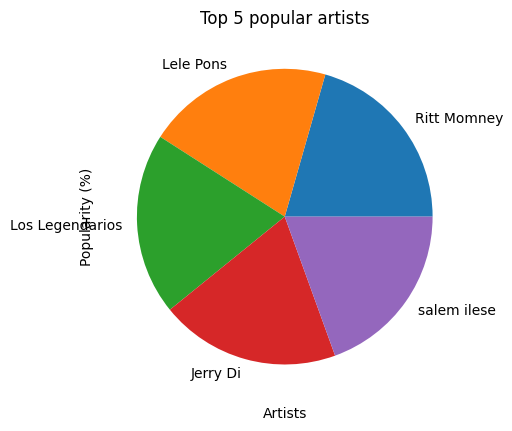

In [ ]:
# Create 3-5 visualizations to better understand the relationships within the data. You are allowed to use the link at the top of this notebook as inspiration, but create different visualizations.
popularity_of_artist = data_by_artist.groupby('artists')['popularity'].sum().sort_values(ascending=False).head()
popularity_of_artist.plot(kind='pie', title='Top 5 popular artists')
plt.xlabel('Artists')
plt.ylabel('Popularity (%)')
plt.show()

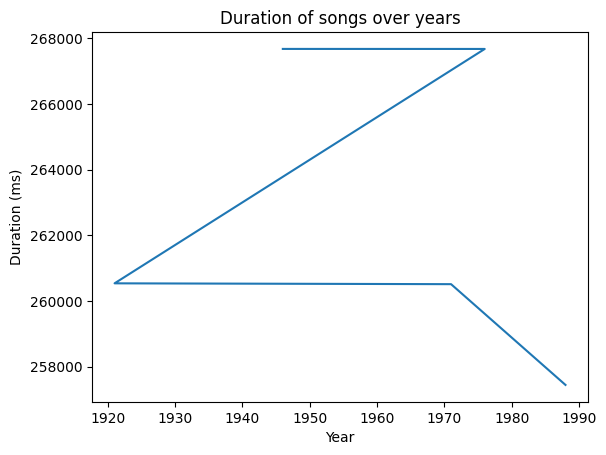

In [ ]:
duration_over_year = data_by_year.groupby('year')['duration_ms'].sum().sort_values(ascending=False).head()
duration_over_year.plot(kind='line', title='Duration of songs over years')
plt.xlabel('Year')
plt.ylabel('Duration (ms)')
plt.show()

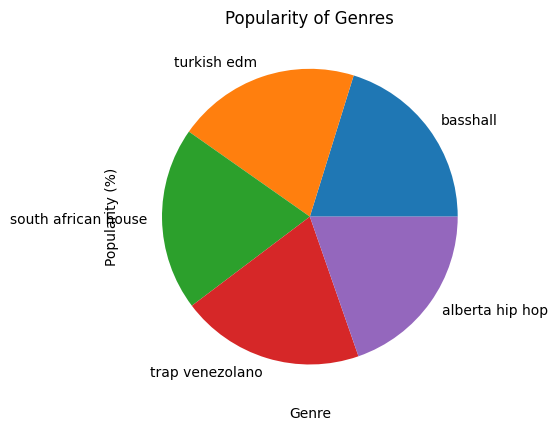

In [ ]:
year = data_by_genres.groupby('genres')['popularity'].sum().sort_values(ascending=False).head()
year.plot(kind='pie', title='Popularity of Genres')
plt.xlabel('Genre')
plt.ylabel('Popularity (%)')
plt.show()

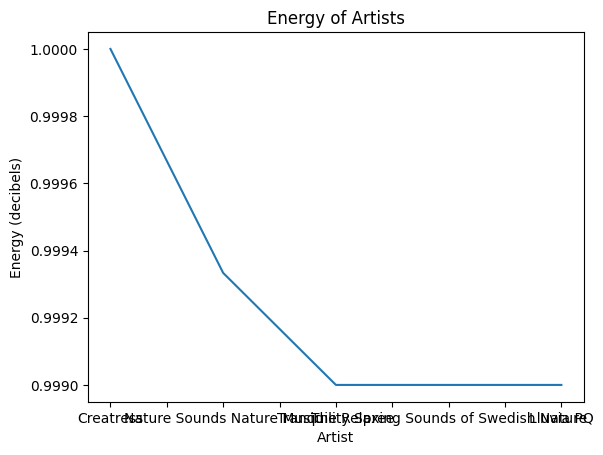

In [ ]:
energy = data_by_artist.groupby('artists')['energy'].sum().sort_values(ascending=False).head()
energy.plot(kind='line', title='Energy of Artists')
plt.xlabel('Artist')
plt.ylabel('Energy (decibels)')
plt.show()

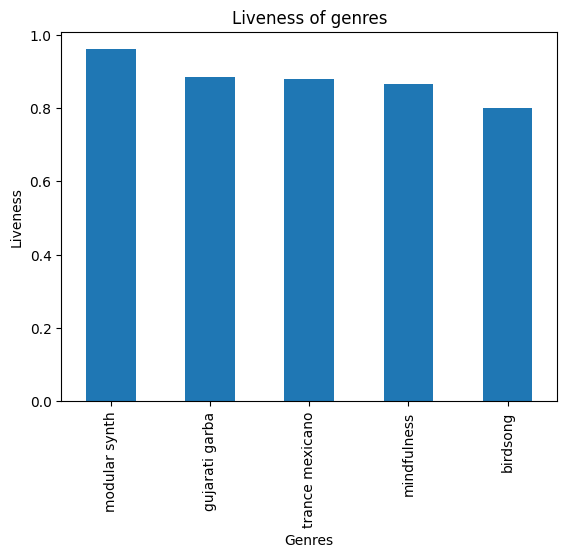

In [ ]:
liveness_genre = data_by_genres.groupby('genres')['liveness'].sum().sort_values(ascending=False).head()
liveness_genre.plot(kind='bar', title='Liveness of genres')
plt.xlabel('Genres')
plt.ylabel('Liveness')
plt.show()

###Build Recommender System

In [ ]:
# Run this cell to install spotipy, a Python client for the Spotify Web API
!pip install spotipy

After installing Spotipy, you will need to create an app on the [Spotify Developer’s page](https://developer.spotify.com/) and save your Client ID and secret key.

In [ ]:
# Run this cell
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict

In [ ]:
# Time to start making the music recommender system
#SPOTIFY_CLIENT_ID= '1153d36f9cb047e6bb7f4f53427a108c'
#SPOTIFY_CLIENT_SECRET = '8414a8be8e96472283f98bcff85153e9'
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="1153d36f9cb047e6bb7f4f53427a108c", client_secret= "8414a8be8e96472283f98bcff85153e9"))

In [ ]:
# Define a function find_song that takes in the name of a song and the year it was released and returns a dataframe of all of the song's data

def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = results['name']
    song_data['year'] = results['year']
    song_data['explicit'] = results['explicit']
    song_data['duration_ms'] = results['duration_ms']
    song_data['popularity'] = results['popularity']

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)


In [ ]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

# Define a function get_song_data that takes in a song and spotify_data and returns the name of the song and the year it was released

def get_song_data(song, spotify_data):

    try:
        song_data = spotify_data[(spotify_data['name'] == song['name'])
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data

    except IndexError:
        return find_song(song['name'], song['year'])


In [ ]:
# Finish defining the get_mean_vector function

def get_mean_vector(song_list, spotify_data):

    song_vectors = []

    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)

    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


In [ ]:
# Finish defining the flatten_dict_list function

def flatten_dict_list(dict_list):

    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []

    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)

    return flattened_dict

In [ ]:
# Run this cell to define the recommend_songs function

def recommend_songs(song_list, spotify_data, n_songs=10):

    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)

    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])

    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [ ]:
# Try out your recommend_songs function here!


